# Inspect data files

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from rompy_xbeach.grid import Ori, RegularGrid

import warnings
warnings.filterwarnings("ignore")

/home/rguedes/.virtualenvs/xbeach/lib/python3.10/site-packages/pyschism/forcing/hycom/gofs.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


## Read bathy

Read bathy from the test data to inspect and help defining the model grid

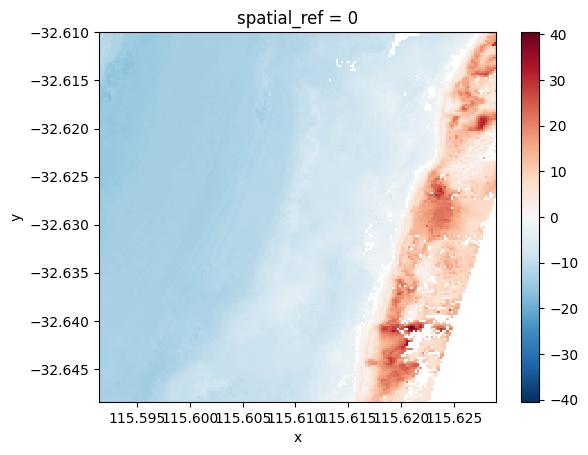

In [4]:
bathy = rioxarray.open_rasterio("../tests/data/bathy.tif")
bathy = bathy.isel(band=0, drop=True)
bathy.plot()

## Set grid

Define the XBeach grid object in `EPSG:28350` projection (use latlon to specify the origin)

In [5]:
grid = RegularGrid(
    ori=Ori(
        x=115.594239,
        y=-32.641104,
        crs="epsg:4326",
    ),
    alfa=347.0,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

## Plot grid on bathy

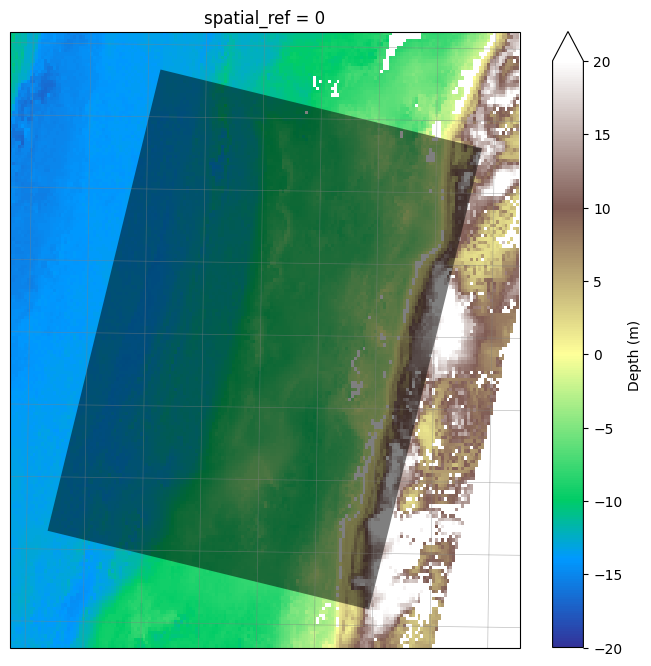

In [6]:
projection = ccrs.Stereographic(
    central_longitude=grid.ori.x, central_latitude=grid.ori.y
)
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(8.5, 8))

# Bathymetry
bathy.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="terrain",
    vmin=-20,
    vmax=20,
    cbar_kwargs=dict(label="Depth (m)"),
)

# Grid
ax = grid.plot(ax=ax, buffer=250, grid_kwargs=dict(facecolor="k", alpha=0.5, zorder=2))

## Set Data object

Define the data with a `SourceGeotiff` source and use the grid created above to create the model files

In [7]:
from rompy_xbeach.source import SourceGeotiff
from rompy_xbeach.data import XBeachDataGrid

### Instantiate the data object

In [8]:
data = XBeachDataGrid(
    source=SourceGeotiff(
        filename="../tests/data/bathy.tif",
    ),
    interpolator=dict(
        model_type="regular_grid",
        kwargs=dict(
            method="linear",
            fill_value=None,
        ),
    )
)

### Interpolate onto the model grid

In [11]:
workspace = Path("./")
workspace.mkdir(exist_ok=True)

xfile, yfile, datafile = data.get(destdir=workspace, grid=grid)
sorted(workspace.glob("*.txt"))

INFO:rompy_xbeach.data:Reprojecting ../tests/data/bathy.tif to EPSG:28350


[PosixPath('data.txt'), PosixPath('xdata.txt'), PosixPath('ydata.txt')]

### Plot the interpolated data

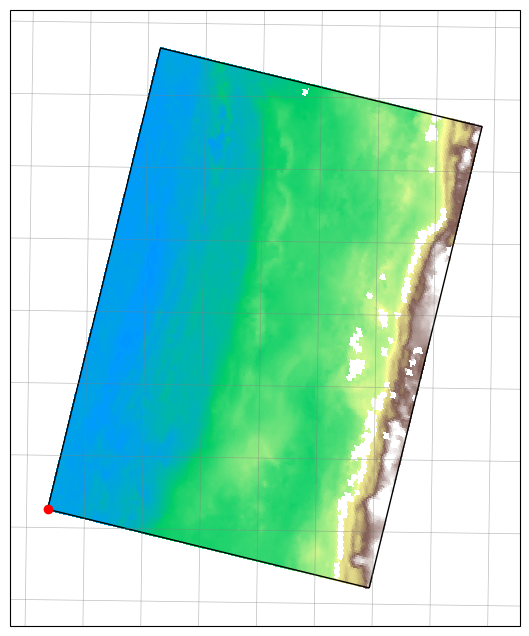

In [12]:
# Read the files created above
x = np.loadtxt(xfile)
y = np.loadtxt(yfile)
data = np.loadtxt(datafile)

# Plot the model data with the grid
fig, ax = plt.subplots(subplot_kw={"projection": projection}, figsize=(8.5, 8))
ax.pcolormesh(x, y, data, transform=grid.transform, vmin=-20, vmax=20, cmap="terrain")
ax = grid.plot(ax=ax, buffer=250, grid_kwargs=dict(edgecolor="k", facecolor="none"))
ax.plot(grid.x0, grid.y0, "ro", transform=grid.transform)

Text(0, 0.5, 'y')

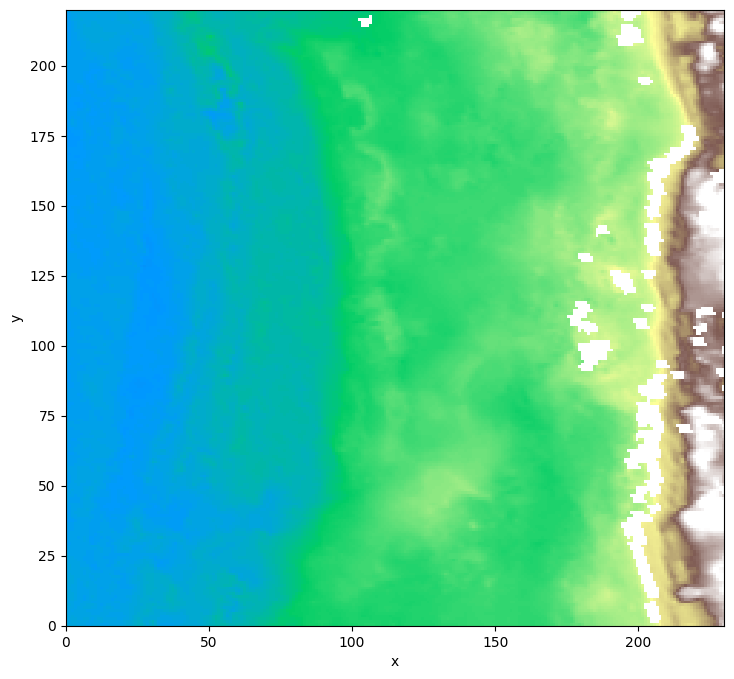

In [26]:
fig, ax = plt.subplots(figsize=(8.5, 8))
ax.pcolormesh(data, vmin=-20, vmax=20, cmap="terrain")
ax.set_xlabel("x")
ax.set_ylabel("y")